In [3]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [4]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
# from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [37]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2021, 2, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "hawkesworth_bridge"

# Factor to multiply by MAPE in classification step
FACTOR = 10

## Reproducible Results

In [6]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [7]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [8]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(path, anomaly_name):
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))
    
    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [9]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [10]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()

    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_data["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_data["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [11]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [12]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [85]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [14]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [15]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [16]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [17]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [18]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [19]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights("{}".format(filename_weights))
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        
        # Load the json
        json_file = open("{}.json".format(filename, 'r'))
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights("{}-weights.h5".format(filename))
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [20]:
# # Talos Optimizer:
# class Optimizer:
    
#     # --------------------------------------------------------------------------------
    
#     # Define some params that will be used in the training function
#     def init(self, look_back, n_features, n_outputs):
#         self.n_timesteps = look_back
#         self.n_features = n_features
#         self.n_outputs = n_outputs
#         self.best_params = None
#     # --------------------------------------------------------------------------------
    
#     # Training function used in parameter optimization
#     ## Creates and trains the model
#     def fit(self, train_data, train_labels, val_data, val_labels, params):

#         print("Params:")
#         print(params)
#         print("\n")
        
#         # Create the model
#         model = Sequential()
        
#         # First Layer
#         model.add(LSTM_keras(units = params["units_1"],
#                                   batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
#                                   activation = params["activation_1"],
#                                   recurrent_activation = params["recurrent_activation_1"],
#                                   use_bias = params["use_bias_1"],
#                                   unit_forget_bias = params["unit_forget_bias_1"],
#                                   dropout = params["dropout_1"],
#                                   recurrent_dropout = params["recurrent_dropout_1"],
#                                   return_sequences = params["return_sequences_1"],
#                                   return_state = params["return_state_1"],
#                                   go_backwards = params["go_backwards_1"],
#                                   stateful = params["stateful_1"],
#                                   unroll = params["unroll_1"]))
        
#         # Second Layer
#         model.add(LSTM_keras(units = params["units_2"],
#                                   activation = params["activation_2"],
#                                   recurrent_activation = params["recurrent_activation_2"],
#                                   use_bias = params["use_bias_2"],
#                                   unit_forget_bias = params["unit_forget_bias_2"],
#                                   dropout = params["dropout_2"],
#                                   recurrent_dropout = params["recurrent_dropout_2"],
#                                   return_sequences = params["return_sequences_2"],
#                                   return_state = params["return_state_2"],
#                                   go_backwards = params["go_backwards_2"],
#                                   stateful = params["stateful_2"],
#                                   unroll = params["unroll_2"]))
               
#         # Output Layer
#         model.add(Dense(self.n_outputs))
    
#         # Compile the model
#         model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

#         # Fit the model
#         history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

#         return(history, model)
#     # --------------------------------------------------------------------------------
    
#     # Hyperparameters optmization function
#     def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
#         # Samples, Time Steps e Features
#         train_data = training_data.to_numpy()
#         train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

#         # If there is no file with the results of optimization, make the experiments
#         if(read == None):
#             scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

#         # Finds the csv name with the results
#         experiments_file = filename + "/" + listdir(filename)[0]

#         # Store the experiments in a DataFrame
#         reporting_data = Reporting(experiments_file).data

#         # Sort the experiments by mse value
#         best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

#         print("Best Hyperparameters:")
#         print(best_experiment)

#         # Organize the results
#         self.best_params = {
            
#                  # Dense Layer 1
#                  'units_1': int(best_experiment["units_1"].values[0]),
#                  'activation_1': best_experiment["activation_1"].values[0],
#                  'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
#                  'use_bias_1': best_experiment["use_bias_1"].values[0],
#                  'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
#                  'dropout_1': best_experiment["dropout_1"].values[0],
#                  'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
#                  'return_sequences_1': best_experiment["return_sequences_1"].values[0],
#                  'return_state_1': best_experiment["return_state_1"].values[0],
#                  'go_backwards_1': best_experiment["go_backwards_1"].values[0],
#                  'stateful_1': best_experiment["stateful_1"].values[0],
#                  'unroll_1': best_experiment["unroll_1"].values[0],

#                  # Dense Layer 2
#                  'units_2': int(best_experiment["units_2"].values[0]),
#                  'activation_2': best_experiment["activation_2"].values[0],
#                  'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
#                  'use_bias_2': best_experiment["use_bias_2"].values[0],
#                  'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
#                  'dropout_2': best_experiment["dropout_2"].values[0],
#                  'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
#                  'return_sequences_2': best_experiment["return_sequences_2"].values[0],
#                  'return_state_2': best_experiment["return_state_2"].values[0],     
#                  'go_backwards_2': best_experiment["go_backwards_2"].values[0],
#                  'stateful_2': best_experiment["stateful_2"].values[0],
#                  'unroll_2': best_experiment["unroll_2"].values[0],

#                 # Compile
#                 'optimizer': best_experiment["optimizer"].values[0],
#                 'loss': best_experiment["loss.1"].values[0],

#                 # Fit
#                 'batch_size': best_experiment["batch_size"].values[0],
#                 'epochs': best_experiment["round_epochs"].values[0],
#                 'validation_split': best_experiment["validation_split"].values[0]
#         }
#         return(self.best_params)
#     # --------------------------------------------------------------------------------
    
# # ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [21]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [133]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
              
        # Stored inside the class
        if(mav is None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------
    
    # Function to define the expected data
    def set_expected_classes(self, labels):
        self.exp_classes = labels.tolist()
    # --------------------------------------------------------------------------------
    
    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

In [23]:
# Function that read the test data (with anomalies)
def read_input(filename):
    data = pd.read_csv(filename)
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

## Pre-Processing

In [49]:
# Read all data
input_data = read_input("input.csv")

# Get only the normal data for regression (label == 0)
only_normal_data = input_data[input_data["label"] == 0]
only_normal_data.drop(columns=["label"])

# Transform into a supervised problem
data_sup = create_supervised_data(only_normal_data, LOOK_BACK)

# Divide into train and test set
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

# ---------------------------------------------------------------------------------
# Get the supervised data for normal and anomaly data
input_data_sup = create_supervised_data(input_data, LOOK_BACK)

# Get columns of interest
x_columns, y_column = get_columns(LOOK_BACK)
df = input_data_sup.reset_index()
   
# Get test data
df_slice = df[df.datetime.dt.date >= TEST_INIT_DATE] 
X_test = df_slice[x_columns]
y_test = df_slice[y_column]

test = {"data": X_test, "labels": y_test}

print("\n  New Test Set:")
print("    - X_test: {}".format(test["data"].shape))
print("    - y_test: {}".format(test["labels"].shape))

  Train:
    - X_train: (51506, 12)
    - y_train: (51506,)

  Test:
    - X_test: (6988, 12)
    - y_test: (6988,)

  New Test Set:
    - X_test: (8665, 12)
    - y_test: (8665,)


In [92]:
# # Read "Spike" data
# anomaly_type = "s"
# raw_data = read_anomaly_data("./csvs/all_data", anomaly_type)

# print("\nRaw Data:")
# print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
# print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# # Group by "MINUTES (1)"
# data = group_by(raw_data, MINUTES)

# print("\nData Shape:")
# print(data.shape)

# # Shift data using the "LOOK_BACK" (12)
# data_sup = create_supervised_data(data, LOOK_BACK)

# # Split data into train and test set
# print("\nDataset:")
# train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

# data_sup.head(30)

## Model: LSTM

In [106]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 150,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-measured-regression-model-2"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
# lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Epoch 1/150
51506/51506 [==============================] - 210s 4ms/step - loss: 0.0477
Epoch 2/150
51506/51506 [==============================] - 211s 4ms/step - loss: 0.0036
Epoch 3/150
51506/51506 [==============================] - 212s 4ms/step - loss: 0.0021
Epoch 4/150
51506/51506 [==============================] - 209s 4ms/step - loss: 0.0035
Epoch 5/150
51506/51506 [==============================] - 206s 4ms/step - loss: 0.0014
Epoch 6/150
51506/51506 [==============================] - 208s 4ms/step - loss: 0.0023
Epoch 7/150
51506/51506 [==============================] - 207s 4ms/step - loss: 0.0018
Epoch 8/150
51506/51506 [==============================] - 207s 4ms/step - loss: 0.0011
Epoch 9/150
51506/51506 [==============================] - 212s 4ms/step - loss: 0.0015
Epoch 10/150
51506/51506 [==============================] - 216s 4ms/step - loss: 0.0010
Epoch 11/150
51506/51506 [==============================] - 215s 4ms/step - loss: 0.0019
Epoch 12/150
51506/51506 [====

51506/51506 [==============================] - 208s 4ms/step - loss: 3.8372e-04
Epoch 91/150
51506/51506 [==============================] - 206s 4ms/step - loss: 2.3825e-04
Epoch 92/150
51506/51506 [==============================] - 206s 4ms/step - loss: 5.1698e-04
Epoch 93/150
51506/51506 [==============================] - 206s 4ms/step - loss: 5.1530e-04
Epoch 94/150
51506/51506 [==============================] - 205s 4ms/step - loss: 4.3189e-04
Epoch 95/150
51506/51506 [==============================] - 210s 4ms/step - loss: 4.5535e-04
Epoch 96/150
51506/51506 [==============================] - 215s 4ms/step - loss: 4.4218e-04
Epoch 97/150
51506/51506 [==============================] - 209s 4ms/step - loss: 6.6080e-04
Epoch 98/150
51506/51506 [==============================] - 213s 4ms/step - loss: 9.1831e-04
Epoch 99/150
51506/51506 [==============================] - 215s 4ms/step - loss: 3.1627e-04
Epoch 100/150
51506/51506 [==============================] - 210s 4ms/step - loss: 


Example 127 / 8665


Example 128 / 8665


Example 129 / 8665


Example 130 / 8665


Example 131 / 8665


Example 132 / 8665


Example 133 / 8665


Example 134 / 8665


Example 135 / 8665


Example 136 / 8665


Example 137 / 8665


Example 138 / 8665


Example 139 / 8665


Example 140 / 8665


Example 141 / 8665


Example 142 / 8665


Example 143 / 8665


Example 144 / 8665


Example 145 / 8665


Example 146 / 8665


Example 147 / 8665


Example 148 / 8665


Example 149 / 8665


Example 150 / 8665


Example 151 / 8665


Example 152 / 8665


Example 153 / 8665


Example 154 / 8665


Example 155 / 8665


Example 156 / 8665


Example 157 / 8665


Example 158 / 8665


Example 159 / 8665


Example 160 / 8665


Example 161 / 8665


Example 162 / 8665


Example 163 / 8665


Example 164 / 8665


Example 165 / 8665


Example 166 / 8665


Example 167 / 8665


Example 168 / 8665


Example 169 / 8665


Example 170 / 8665


Example 171 / 8665


Example 172 / 8665


Example 173 / 8665


Example 174 


Example 523 / 8665


Example 524 / 8665


Example 525 / 8665


Example 526 / 8665


Example 527 / 8665


Example 528 / 8665


Example 529 / 8665


Example 530 / 8665


Example 531 / 8665


Example 532 / 8665


Example 533 / 8665


Example 534 / 8665


Example 535 / 8665


Example 536 / 8665


Example 537 / 8665


Example 538 / 8665


Example 539 / 8665


Example 540 / 8665


Example 541 / 8665


Example 542 / 8665


Example 543 / 8665


Example 544 / 8665


Example 545 / 8665


Example 546 / 8665


Example 547 / 8665


Example 548 / 8665


Example 549 / 8665


Example 550 / 8665


Example 551 / 8665


Example 552 / 8665


Example 553 / 8665


Example 554 / 8665


Example 555 / 8665


Example 556 / 8665


Example 557 / 8665


Example 558 / 8665


Example 559 / 8665


Example 560 / 8665


Example 561 / 8665


Example 562 / 8665


Example 563 / 8665


Example 564 / 8665


Example 565 / 8665


Example 566 / 8665


Example 567 / 8665


Example 568 / 8665


Example 569 / 8665


Example 570 


Example 919 / 8665


Example 920 / 8665


Example 921 / 8665


Example 922 / 8665


Example 923 / 8665


Example 924 / 8665


Example 925 / 8665


Example 926 / 8665


Example 927 / 8665


Example 928 / 8665


Example 929 / 8665


Example 930 / 8665


Example 931 / 8665


Example 932 / 8665


Example 933 / 8665


Example 934 / 8665


Example 935 / 8665


Example 936 / 8665


Example 937 / 8665


Example 938 / 8665


Example 939 / 8665


Example 940 / 8665


Example 941 / 8665


Example 942 / 8665


Example 943 / 8665


Example 944 / 8665


Example 945 / 8665


Example 946 / 8665


Example 947 / 8665


Example 948 / 8665


Example 949 / 8665


Example 950 / 8665


Example 951 / 8665


Example 952 / 8665


Example 953 / 8665


Example 954 / 8665


Example 955 / 8665


Example 956 / 8665


Example 957 / 8665


Example 958 / 8665


Example 959 / 8665


Example 960 / 8665


Example 961 / 8665


Example 962 / 8665


Example 963 / 8665


Example 964 / 8665


Example 965 / 8665


Example 966 


Example 1297 / 8665


Example 1298 / 8665


Example 1299 / 8665


Example 1300 / 8665


Example 1301 / 8665


Example 1302 / 8665


Example 1303 / 8665


Example 1304 / 8665


Example 1305 / 8665


Example 1306 / 8665


Example 1307 / 8665


Example 1308 / 8665


Example 1309 / 8665


Example 1310 / 8665


Example 1311 / 8665


Example 1312 / 8665


Example 1313 / 8665


Example 1314 / 8665


Example 1315 / 8665


Example 1316 / 8665


Example 1317 / 8665


Example 1318 / 8665


Example 1319 / 8665


Example 1320 / 8665


Example 1321 / 8665


Example 1322 / 8665


Example 1323 / 8665


Example 1324 / 8665


Example 1325 / 8665


Example 1326 / 8665


Example 1327 / 8665


Example 1328 / 8665


Example 1329 / 8665


Example 1330 / 8665


Example 1331 / 8665


Example 1332 / 8665


Example 1333 / 8665


Example 1334 / 8665


Example 1335 / 8665


Example 1336 / 8665


Example 1337 / 8665


Example 1338 / 8665


Example 1339 / 8665


Example 1340 / 8665


Example 1341 / 8665


Example 1


Example 1675 / 8665


Example 1676 / 8665


Example 1677 / 8665


Example 1678 / 8665


Example 1679 / 8665


Example 1680 / 8665


Example 1681 / 8665


Example 1682 / 8665


Example 1683 / 8665


Example 1684 / 8665


Example 1685 / 8665


Example 1686 / 8665


Example 1687 / 8665


Example 1688 / 8665


Example 1689 / 8665


Example 1690 / 8665


Example 1691 / 8665


Example 1692 / 8665


Example 1693 / 8665


Example 1694 / 8665


Example 1695 / 8665


Example 1696 / 8665


Example 1697 / 8665


Example 1698 / 8665


Example 1699 / 8665


Example 1700 / 8665


Example 1701 / 8665


Example 1702 / 8665


Example 1703 / 8665


Example 1704 / 8665


Example 1705 / 8665


Example 1706 / 8665


Example 1707 / 8665


Example 1708 / 8665


Example 1709 / 8665


Example 1710 / 8665


Example 1711 / 8665


Example 1712 / 8665


Example 1713 / 8665


Example 1714 / 8665


Example 1715 / 8665


Example 1716 / 8665


Example 1717 / 8665


Example 1718 / 8665


Example 1719 / 8665


Example 1


Example 2048 / 8665


Example 2049 / 8665


Example 2050 / 8665


Example 2051 / 8665


Example 2052 / 8665


Example 2053 / 8665


Example 2054 / 8665


Example 2055 / 8665


Example 2056 / 8665


Example 2057 / 8665


Example 2058 / 8665


Example 2059 / 8665


Example 2060 / 8665


Example 2061 / 8665


Example 2062 / 8665


Example 2063 / 8665


Example 2064 / 8665


Example 2065 / 8665


Example 2066 / 8665


Example 2067 / 8665


Example 2068 / 8665


Example 2069 / 8665


Example 2070 / 8665


Example 2071 / 8665


Example 2072 / 8665


Example 2073 / 8665


Example 2074 / 8665


Example 2075 / 8665


Example 2076 / 8665


Example 2077 / 8665


Example 2078 / 8665


Example 2079 / 8665


Example 2080 / 8665


Example 2081 / 8665


Example 2082 / 8665


Example 2083 / 8665


Example 2084 / 8665


Example 2085 / 8665


Example 2086 / 8665


Example 2087 / 8665


Example 2088 / 8665


Example 2089 / 8665


Example 2090 / 8665


Example 2091 / 8665


Example 2092 / 8665


Example 2


Example 2426 / 8665


Example 2427 / 8665


Example 2428 / 8665


Example 2429 / 8665


Example 2430 / 8665


Example 2431 / 8665


Example 2432 / 8665


Example 2433 / 8665


Example 2434 / 8665


Example 2435 / 8665


Example 2436 / 8665


Example 2437 / 8665


Example 2438 / 8665


Example 2439 / 8665


Example 2440 / 8665


Example 2441 / 8665


Example 2442 / 8665


Example 2443 / 8665


Example 2444 / 8665


Example 2445 / 8665


Example 2446 / 8665


Example 2447 / 8665


Example 2448 / 8665


Example 2449 / 8665


Example 2450 / 8665


Example 2451 / 8665


Example 2452 / 8665


Example 2453 / 8665


Example 2454 / 8665


Example 2455 / 8665


Example 2456 / 8665


Example 2457 / 8665


Example 2458 / 8665


Example 2459 / 8665


Example 2460 / 8665


Example 2461 / 8665


Example 2462 / 8665


Example 2463 / 8665


Example 2464 / 8665


Example 2465 / 8665


Example 2466 / 8665


Example 2467 / 8665


Example 2468 / 8665


Example 2469 / 8665


Example 2470 / 8665


Example 2


Example 2801 / 8665


Example 2802 / 8665


Example 2803 / 8665


Example 2804 / 8665


Example 2805 / 8665


Example 2806 / 8665


Example 2807 / 8665


Example 2808 / 8665


Example 2809 / 8665


Example 2810 / 8665


Example 2811 / 8665


Example 2812 / 8665


Example 2813 / 8665


Example 2814 / 8665


Example 2815 / 8665


Example 2816 / 8665


Example 2817 / 8665


Example 2818 / 8665


Example 2819 / 8665


Example 2820 / 8665


Example 2821 / 8665


Example 2822 / 8665


Example 2823 / 8665


Example 2824 / 8665


Example 2825 / 8665


Example 2826 / 8665


Example 2827 / 8665


Example 2828 / 8665


Example 2829 / 8665


Example 2830 / 8665


Example 2831 / 8665


Example 2832 / 8665


Example 2833 / 8665


Example 2834 / 8665


Example 2835 / 8665


Example 2836 / 8665


Example 2837 / 8665


Example 2838 / 8665


Example 2839 / 8665


Example 2840 / 8665


Example 2841 / 8665


Example 2842 / 8665


Example 2843 / 8665


Example 2844 / 8665


Example 2845 / 8665


Example 2


Example 3177 / 8665


Example 3178 / 8665


Example 3179 / 8665


Example 3180 / 8665


Example 3181 / 8665


Example 3182 / 8665


Example 3183 / 8665


Example 3184 / 8665


Example 3185 / 8665


Example 3186 / 8665


Example 3187 / 8665


Example 3188 / 8665


Example 3189 / 8665


Example 3190 / 8665


Example 3191 / 8665


Example 3192 / 8665


Example 3193 / 8665


Example 3194 / 8665


Example 3195 / 8665


Example 3196 / 8665


Example 3197 / 8665


Example 3198 / 8665


Example 3199 / 8665


Example 3200 / 8665


Example 3201 / 8665


Example 3202 / 8665


Example 3203 / 8665


Example 3204 / 8665


Example 3205 / 8665


Example 3206 / 8665


Example 3207 / 8665


Example 3208 / 8665


Example 3209 / 8665


Example 3210 / 8665


Example 3211 / 8665


Example 3212 / 8665


Example 3213 / 8665


Example 3214 / 8665


Example 3215 / 8665


Example 3216 / 8665


Example 3217 / 8665


Example 3218 / 8665


Example 3219 / 8665


Example 3220 / 8665


Example 3221 / 8665


Example 3


Example 3555 / 8665


Example 3556 / 8665


Example 3557 / 8665


Example 3558 / 8665


Example 3559 / 8665


Example 3560 / 8665


Example 3561 / 8665


Example 3562 / 8665


Example 3563 / 8665


Example 3564 / 8665


Example 3565 / 8665


Example 3566 / 8665


Example 3567 / 8665


Example 3568 / 8665


Example 3569 / 8665


Example 3570 / 8665


Example 3571 / 8665


Example 3572 / 8665


Example 3573 / 8665


Example 3574 / 8665


Example 3575 / 8665


Example 3576 / 8665


Example 3577 / 8665


Example 3578 / 8665


Example 3579 / 8665


Example 3580 / 8665


Example 3581 / 8665


Example 3582 / 8665


Example 3583 / 8665


Example 3584 / 8665


Example 3585 / 8665


Example 3586 / 8665


Example 3587 / 8665


Example 3588 / 8665


Example 3589 / 8665


Example 3590 / 8665


Example 3591 / 8665


Example 3592 / 8665


Example 3593 / 8665


Example 3594 / 8665


Example 3595 / 8665


Example 3596 / 8665


Example 3597 / 8665


Example 3598 / 8665


Example 3599 / 8665


Example 3


Example 3930 / 8665


Example 3931 / 8665


Example 3932 / 8665


Example 3933 / 8665


Example 3934 / 8665


Example 3935 / 8665


Example 3936 / 8665


Example 3937 / 8665


Example 3938 / 8665


Example 3939 / 8665


Example 3940 / 8665


Example 3941 / 8665


Example 3942 / 8665


Example 3943 / 8665


Example 3944 / 8665


Example 3945 / 8665


Example 3946 / 8665


Example 3947 / 8665


Example 3948 / 8665


Example 3949 / 8665


Example 3950 / 8665


Example 3951 / 8665


Example 3952 / 8665


Example 3953 / 8665


Example 3954 / 8665


Example 3955 / 8665


Example 3956 / 8665


Example 3957 / 8665


Example 3958 / 8665


Example 3959 / 8665


Example 3960 / 8665


Example 3961 / 8665


Example 3962 / 8665


Example 3963 / 8665


Example 3964 / 8665


Example 3965 / 8665


Example 3966 / 8665


Example 3967 / 8665


Example 3968 / 8665


Example 3969 / 8665


Example 3970 / 8665


Example 3971 / 8665


Example 3972 / 8665


Example 3973 / 8665


Example 3974 / 8665


Example 3


Example 4308 / 8665


Example 4309 / 8665


Example 4310 / 8665


Example 4311 / 8665


Example 4312 / 8665


Example 4313 / 8665


Example 4314 / 8665


Example 4315 / 8665


Example 4316 / 8665


Example 4317 / 8665


Example 4318 / 8665


Example 4319 / 8665


Example 4320 / 8665


Example 4321 / 8665


Example 4322 / 8665


Example 4323 / 8665


Example 4324 / 8665


Example 4325 / 8665


Example 4326 / 8665


Example 4327 / 8665


Example 4328 / 8665


Example 4329 / 8665


Example 4330 / 8665


Example 4331 / 8665


Example 4332 / 8665


Example 4333 / 8665


Example 4334 / 8665


Example 4335 / 8665


Example 4336 / 8665


Example 4337 / 8665


Example 4338 / 8665


Example 4339 / 8665


Example 4340 / 8665


Example 4341 / 8665


Example 4342 / 8665


Example 4343 / 8665


Example 4344 / 8665


Example 4345 / 8665


Example 4346 / 8665


Example 4347 / 8665


Example 4348 / 8665


Example 4349 / 8665


Example 4350 / 8665


Example 4351 / 8665


Example 4352 / 8665


Example 4


Example 4684 / 8665


Example 4685 / 8665


Example 4686 / 8665


Example 4687 / 8665


Example 4688 / 8665


Example 4689 / 8665


Example 4690 / 8665


Example 4691 / 8665


Example 4692 / 8665


Example 4693 / 8665


Example 4694 / 8665


Example 4695 / 8665


Example 4696 / 8665


Example 4697 / 8665


Example 4698 / 8665


Example 4699 / 8665


Example 4700 / 8665


Example 4701 / 8665


Example 4702 / 8665


Example 4703 / 8665


Example 4704 / 8665


Example 4705 / 8665


Example 4706 / 8665


Example 4707 / 8665


Example 4708 / 8665


Example 4709 / 8665


Example 4710 / 8665


Example 4711 / 8665


Example 4712 / 8665


Example 4713 / 8665


Example 4714 / 8665


Example 4715 / 8665


Example 4716 / 8665


Example 4717 / 8665


Example 4718 / 8665


Example 4719 / 8665


Example 4720 / 8665


Example 4721 / 8665


Example 4722 / 8665


Example 4723 / 8665


Example 4724 / 8665


Example 4725 / 8665


Example 4726 / 8665


Example 4727 / 8665


Example 4728 / 8665


Example 4


Example 5062 / 8665


Example 5063 / 8665


Example 5064 / 8665


Example 5065 / 8665


Example 5066 / 8665


Example 5067 / 8665


Example 5068 / 8665


Example 5069 / 8665


Example 5070 / 8665


Example 5071 / 8665


Example 5072 / 8665


Example 5073 / 8665


Example 5074 / 8665


Example 5075 / 8665


Example 5076 / 8665


Example 5077 / 8665


Example 5078 / 8665


Example 5079 / 8665


Example 5080 / 8665


Example 5081 / 8665


Example 5082 / 8665


Example 5083 / 8665


Example 5084 / 8665


Example 5085 / 8665


Example 5086 / 8665


Example 5087 / 8665


Example 5088 / 8665


Example 5089 / 8665


Example 5090 / 8665


Example 5091 / 8665


Example 5092 / 8665


Example 5093 / 8665


Example 5094 / 8665


Example 5095 / 8665


Example 5096 / 8665


Example 5097 / 8665


Example 5098 / 8665


Example 5099 / 8665


Example 5100 / 8665


Example 5101 / 8665


Example 5102 / 8665


Example 5103 / 8665


Example 5104 / 8665


Example 5105 / 8665


Example 5106 / 8665


Example 5


Example 5439 / 8665


Example 5440 / 8665


Example 5441 / 8665


Example 5442 / 8665


Example 5443 / 8665


Example 5444 / 8665


Example 5445 / 8665


Example 5446 / 8665


Example 5447 / 8665


Example 5448 / 8665


Example 5449 / 8665


Example 5450 / 8665


Example 5451 / 8665


Example 5452 / 8665


Example 5453 / 8665


Example 5454 / 8665


Example 5455 / 8665


Example 5456 / 8665


Example 5457 / 8665


Example 5458 / 8665


Example 5459 / 8665


Example 5460 / 8665


Example 5461 / 8665


Example 5462 / 8665


Example 5463 / 8665


Example 5464 / 8665


Example 5465 / 8665


Example 5466 / 8665


Example 5467 / 8665


Example 5468 / 8665


Example 5469 / 8665


Example 5470 / 8665


Example 5471 / 8665


Example 5472 / 8665


Example 5473 / 8665


Example 5474 / 8665


Example 5475 / 8665


Example 5476 / 8665


Example 5477 / 8665


Example 5478 / 8665


Example 5479 / 8665


Example 5480 / 8665


Example 5481 / 8665


Example 5482 / 8665


Example 5483 / 8665


Example 5


Example 5814 / 8665


Example 5815 / 8665


Example 5816 / 8665


Example 5817 / 8665


Example 5818 / 8665


Example 5819 / 8665


Example 5820 / 8665


Example 5821 / 8665


Example 5822 / 8665


Example 5823 / 8665


Example 5824 / 8665


Example 5825 / 8665


Example 5826 / 8665


Example 5827 / 8665


Example 5828 / 8665


Example 5829 / 8665


Example 5830 / 8665


Example 5831 / 8665


Example 5832 / 8665


Example 5833 / 8665


Example 5834 / 8665


Example 5835 / 8665


Example 5836 / 8665


Example 5837 / 8665


Example 5838 / 8665


Example 5839 / 8665


Example 5840 / 8665


Example 5841 / 8665


Example 5842 / 8665


Example 5843 / 8665


Example 5844 / 8665


Example 5845 / 8665


Example 5846 / 8665


Example 5847 / 8665


Example 5848 / 8665


Example 5849 / 8665


Example 5850 / 8665


Example 5851 / 8665


Example 5852 / 8665


Example 5853 / 8665


Example 5854 / 8665


Example 5855 / 8665


Example 5856 / 8665


Example 5857 / 8665


Example 5858 / 8665


Example 5


Example 6192 / 8665


Example 6193 / 8665


Example 6194 / 8665


Example 6195 / 8665


Example 6196 / 8665


Example 6197 / 8665


Example 6198 / 8665


Example 6199 / 8665


Example 6200 / 8665


Example 6201 / 8665


Example 6202 / 8665


Example 6203 / 8665


Example 6204 / 8665


Example 6205 / 8665


Example 6206 / 8665


Example 6207 / 8665


Example 6208 / 8665


Example 6209 / 8665


Example 6210 / 8665


Example 6211 / 8665


Example 6212 / 8665


Example 6213 / 8665


Example 6214 / 8665


Example 6215 / 8665


Example 6216 / 8665


Example 6217 / 8665


Example 6218 / 8665


Example 6219 / 8665


Example 6220 / 8665


Example 6221 / 8665


Example 6222 / 8665


Example 6223 / 8665


Example 6224 / 8665


Example 6225 / 8665


Example 6226 / 8665


Example 6227 / 8665


Example 6228 / 8665


Example 6229 / 8665


Example 6230 / 8665


Example 6231 / 8665


Example 6232 / 8665


Example 6233 / 8665


Example 6234 / 8665


Example 6235 / 8665


Example 6236 / 8665


Example 6


Example 6570 / 8665


Example 6571 / 8665


Example 6572 / 8665


Example 6573 / 8665


Example 6574 / 8665


Example 6575 / 8665


Example 6576 / 8665


Example 6577 / 8665


Example 6578 / 8665


Example 6579 / 8665


Example 6580 / 8665


Example 6581 / 8665


Example 6582 / 8665


Example 6583 / 8665


Example 6584 / 8665


Example 6585 / 8665


Example 6586 / 8665


Example 6587 / 8665


Example 6588 / 8665


Example 6589 / 8665


Example 6590 / 8665


Example 6591 / 8665


Example 6592 / 8665


Example 6593 / 8665


Example 6594 / 8665


Example 6595 / 8665


Example 6596 / 8665


Example 6597 / 8665


Example 6598 / 8665


Example 6599 / 8665


Example 6600 / 8665


Example 6601 / 8665


Example 6602 / 8665


Example 6603 / 8665


Example 6604 / 8665


Example 6605 / 8665


Example 6606 / 8665


Example 6607 / 8665


Example 6608 / 8665


Example 6609 / 8665


Example 6610 / 8665


Example 6611 / 8665


Example 6612 / 8665


Example 6613 / 8665


Example 6614 / 8665


Example 6


Example 6943 / 8665


Example 6944 / 8665


Example 6945 / 8665


Example 6946 / 8665


Example 6947 / 8665


Example 6948 / 8665


Example 6949 / 8665


Example 6950 / 8665


Example 6951 / 8665


Example 6952 / 8665


Example 6953 / 8665


Example 6954 / 8665


Example 6955 / 8665


Example 6956 / 8665


Example 6957 / 8665


Example 6958 / 8665


Example 6959 / 8665


Example 6960 / 8665


Example 6961 / 8665


Example 6962 / 8665


Example 6963 / 8665


Example 6964 / 8665


Example 6965 / 8665


Example 6966 / 8665


Example 6967 / 8665


Example 6968 / 8665


Example 6969 / 8665


Example 6970 / 8665


Example 6971 / 8665


Example 6972 / 8665


Example 6973 / 8665


Example 6974 / 8665


Example 6975 / 8665


Example 6976 / 8665


Example 6977 / 8665


Example 6978 / 8665


Example 6979 / 8665


Example 6980 / 8665


Example 6981 / 8665


Example 6982 / 8665


Example 6983 / 8665


Example 6984 / 8665


Example 6985 / 8665


Example 6986 / 8665


Example 6987 / 8665


Example 6


Example 7317 / 8665


Example 7318 / 8665


Example 7319 / 8665


Example 7320 / 8665


Example 7321 / 8665


Example 7322 / 8665


Example 7323 / 8665


Example 7324 / 8665


Example 7325 / 8665


Example 7326 / 8665


Example 7327 / 8665


Example 7328 / 8665


Example 7329 / 8665


Example 7330 / 8665


Example 7331 / 8665


Example 7332 / 8665


Example 7333 / 8665


Example 7334 / 8665


Example 7335 / 8665


Example 7336 / 8665


Example 7337 / 8665


Example 7338 / 8665


Example 7339 / 8665


Example 7340 / 8665


Example 7341 / 8665


Example 7342 / 8665


Example 7343 / 8665


Example 7344 / 8665


Example 7345 / 8665


Example 7346 / 8665


Example 7347 / 8665


Example 7348 / 8665


Example 7349 / 8665


Example 7350 / 8665


Example 7351 / 8665


Example 7352 / 8665


Example 7353 / 8665


Example 7354 / 8665


Example 7355 / 8665


Example 7356 / 8665


Example 7357 / 8665


Example 7358 / 8665


Example 7359 / 8665


Example 7360 / 8665


Example 7361 / 8665


Example 7


Example 7694 / 8665


Example 7695 / 8665


Example 7696 / 8665


Example 7697 / 8665


Example 7698 / 8665


Example 7699 / 8665


Example 7700 / 8665


Example 7701 / 8665


Example 7702 / 8665


Example 7703 / 8665


Example 7704 / 8665


Example 7705 / 8665


Example 7706 / 8665


Example 7707 / 8665


Example 7708 / 8665


Example 7709 / 8665


Example 7710 / 8665


Example 7711 / 8665


Example 7712 / 8665


Example 7713 / 8665


Example 7714 / 8665


Example 7715 / 8665


Example 7716 / 8665


Example 7717 / 8665


Example 7718 / 8665


Example 7719 / 8665


Example 7720 / 8665


Example 7721 / 8665


Example 7722 / 8665


Example 7723 / 8665


Example 7724 / 8665


Example 7725 / 8665


Example 7726 / 8665


Example 7727 / 8665


Example 7728 / 8665


Example 7729 / 8665


Example 7730 / 8665


Example 7731 / 8665


Example 7732 / 8665


Example 7733 / 8665


Example 7734 / 8665


Example 7735 / 8665


Example 7736 / 8665


Example 7737 / 8665


Example 7738 / 8665


Example 7


Example 8072 / 8665


Example 8073 / 8665


Example 8074 / 8665


Example 8075 / 8665


Example 8076 / 8665


Example 8077 / 8665


Example 8078 / 8665


Example 8079 / 8665


Example 8080 / 8665


Example 8081 / 8665


Example 8082 / 8665


Example 8083 / 8665


Example 8084 / 8665


Example 8085 / 8665


Example 8086 / 8665


Example 8087 / 8665


Example 8088 / 8665


Example 8089 / 8665


Example 8090 / 8665


Example 8091 / 8665


Example 8092 / 8665


Example 8093 / 8665


Example 8094 / 8665


Example 8095 / 8665


Example 8096 / 8665


Example 8097 / 8665


Example 8098 / 8665


Example 8099 / 8665


Example 8100 / 8665


Example 8101 / 8665


Example 8102 / 8665


Example 8103 / 8665


Example 8104 / 8665


Example 8105 / 8665


Example 8106 / 8665


Example 8107 / 8665


Example 8108 / 8665


Example 8109 / 8665


Example 8110 / 8665


Example 8111 / 8665


Example 8112 / 8665


Example 8113 / 8665


Example 8114 / 8665


Example 8115 / 8665


Example 8116 / 8665


Example 8


Example 8447 / 8665


Example 8448 / 8665


Example 8449 / 8665


Example 8450 / 8665


Example 8451 / 8665


Example 8452 / 8665


Example 8453 / 8665


Example 8454 / 8665


Example 8455 / 8665


Example 8456 / 8665


Example 8457 / 8665


Example 8458 / 8665


Example 8459 / 8665


Example 8460 / 8665


Example 8461 / 8665


Example 8462 / 8665


Example 8463 / 8665


Example 8464 / 8665


Example 8465 / 8665


Example 8466 / 8665


Example 8467 / 8665


Example 8468 / 8665


Example 8469 / 8665


Example 8470 / 8665


Example 8471 / 8665


Example 8472 / 8665


Example 8473 / 8665


Example 8474 / 8665


Example 8475 / 8665


Example 8476 / 8665


Example 8477 / 8665


Example 8478 / 8665


Example 8479 / 8665


Example 8480 / 8665


Example 8481 / 8665


Example 8482 / 8665


Example 8483 / 8665


Example 8484 / 8665


Example 8485 / 8665


Example 8486 / 8665


Example 8487 / 8665


Example 8488 / 8665


Example 8489 / 8665


Example 8490 / 8665


Example 8491 / 8665


Example 8

        1810 => 0.4359
        1811 => 0.07646
        1812 => 0.01874
        1813 => 0.006252
        1814 => 0.01422
        1815 => 0.01607
        1816 => 0.01953
        1817 => 0.01953
        1818 => 0.2355
        1819 => 0.05892
        1820 => 0.0004713
        1821 => 0.01911
        1822 => 0.05295
        1823 => 0.03892
        1824 => 0.0463
        1825 => 0.03267
        1826 => 0.03257
        1827 => 0.01453
        1828 => 0.007341
        1829 => 0.0001357
        1830 => 0.0002666
        1831 => 0.000644
        1832 => 0.0006762
        1833 => 0.0004404
        1834 => 0.0001882
        1835 => 0.000281
        1836 => 0.0003104
        1837 => 0.0002613
        1838 => 0.0001879
        1839 => 0.0001738
        1840 => 0.001935
        1841 => 0.001528
        1842 => 0.0002879
        1843 => 0.0001431
        1844 => 0.0003929
        1845 => 0.0004398
        1846 => 0.000477
        1847 => 0.0003244
        1848 => 0.0001694
        1849 => 8.154e-05
  

        3634 => 0.001224
        3635 => 0.001591
        3636 => 0.0007047
        3637 => 0.0003696
        3638 => 0.00165
        3639 => 0.001164
        3640 => 0.0009538
        3641 => 0.0006057
        3642 => 0.0005025
        3643 => 0.0003075
        3644 => 0.0001072
        3645 => 9.551e-05
        3646 => 0.001928
        3647 => 0.002481
        3648 => 0.001488
        3649 => 0.00104
        3650 => 0.0003072
        3651 => 0.0008046
        3652 => 0.0009959
        3653 => 0.0009397
        3654 => 0.000705
        3655 => 0.0004782
        3656 => 0.00104
        3657 => 0.01052
        3658 => 0.003812
        3659 => 0.008903
        3660 => 0.002527
        3661 => 0.01043
        3662 => 0.00485
        3663 => 0.004531
        3664 => 0.005613
        3665 => 0.006803
        3666 => 0.01343
        3667 => 0.006152
        3668 => 0.005368
        3669 => 0.008518
        3670 => 0.0006357
        3671 => 0.0009491
        3672 => 0.001782
        3673 => 2

        5189 => 0.00136
        5190 => 0.003105
        5191 => 0.6276
        5192 => 0.2359
        5193 => 0.02852
        5194 => 0.0085
        5195 => 0.01117
        5196 => 0.01021
        5197 => 0.005347
        5198 => 0.6315
        5199 => 0.09934
        5200 => 0.05792
        5201 => 0.1691
        5202 => 0.01805
        5203 => 0.01041
        5204 => 0.0549
        5205 => 0.03569
        5206 => 0.05851
        5207 => 0.04457
        5208 => 0.08327
        5209 => 0.02732
        5210 => 0.003829
        5211 => 1.851e-05
        5212 => 0.005032
        5213 => 0.002256
        5214 => 0.002317
        5215 => 0.000975
        5216 => 0.913
        5217 => 0.7529
        5218 => 0.1791
        5219 => 0.04835
        5220 => 0.08562
        5221 => 0.01368
        5222 => 0.04858
        5223 => 0.01819
        5224 => 0.02071
        5225 => 0.01399
        5226 => 0.0635
        5227 => 0.4376
        5228 => 0.332
        5229 => 0.09676
        5230 => 0.024

        6833 => 0.1282
        6834 => 0.09851
        6835 => 0.2039
        6836 => 0.003767
        6837 => 0.002896
        6838 => 0.002339
        6839 => 0.00228
        6840 => 0.00443
        6841 => 0.002505
        6842 => 0.009327
        6843 => 0.8708
        6844 => 0.4396
        6845 => 0.5457
        6846 => 0.5715
        6847 => 0.5409
        6848 => 0.5787
        6849 => 0.3193
        6850 => 0.1108
        6851 => 0.06304
        6852 => 0.01601
        6853 => 0.02632
        6854 => 0.01499
        6855 => 0.02522
        6856 => 0.01686
        6857 => 0.01505
        6858 => 0.8847
        6859 => 0.4303
        6860 => 0.5349
        6861 => 0.559
        6862 => 0.5248
        6863 => 0.5712
        6864 => 0.54
        6865 => 0.5751
        6866 => 0.5592
        6867 => 0.2693
        6868 => 0.08486
        6869 => 0.0105
        6870 => 0.01352
        6871 => 0.01809
        6872 => 0.02284
        6873 => 0.02255
        6874 => 0.01733
        687

        8519 => 0.004645
        8520 => 0.005358
        8521 => 0.003082
        8522 => 0.0004637
        8523 => 0.005629
        8524 => 0.01282
        8525 => 0.007795
        8526 => 0.01239
        8527 => 0.002144
        8528 => 0.00278
        8529 => 0.0001427
        8530 => 0.001128
        8531 => 0.0001899
        8532 => 0.006884
        8533 => 0.00296
        8534 => 0.006409
        8535 => 0.007734
        8536 => 0.00141
        8537 => 0.001506
        8538 => 0.004221
        8539 => 0.003353
        8540 => 0.005387
        8541 => 0.006255
        8542 => 0.001624
        8543 => 0.007177
        8544 => 0.00407
        8545 => 0.002296
        8546 => 0.01164
        8547 => 0.007679
        8548 => 0.6543
        8549 => 0.2516
        8550 => 0.1332
        8551 => 0.04961
        8552 => 0.02664
        8553 => 0.01828
        8554 => 0.01769
        8555 => 0.01091
        8556 => 0.6695
        8557 => 0.02488
        8558 => 0.01175
        8559 => 0.0

## Plot: Expected VS Predicted

In [107]:
date_interval = input_data.copy()
date_interval["datetime"] = pd.to_datetime(input_data["datetime"])
date_interval = date_interval.set_index(['datetime'])

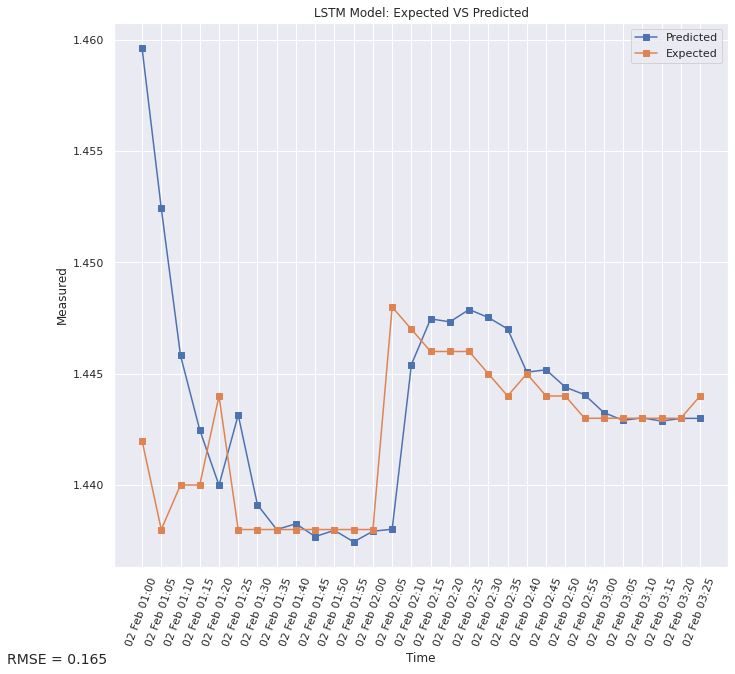

In [108]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], date_interval.index, start, end)

## Scatter Plot

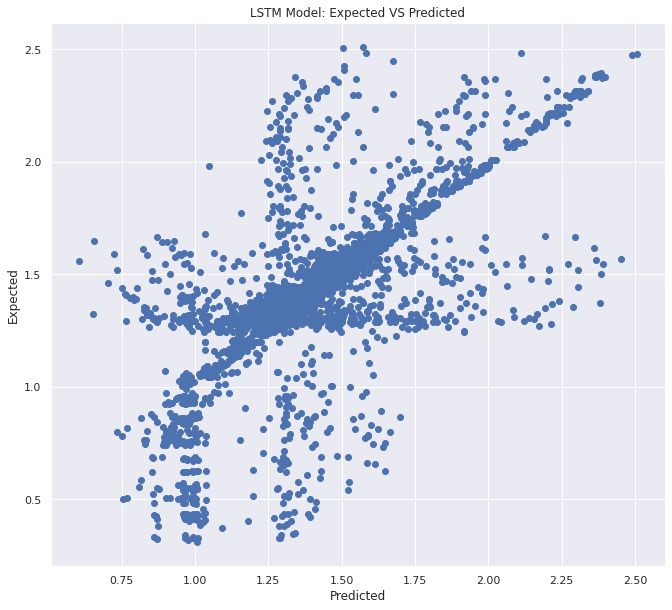

In [109]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

## 7) S + SV + SD

In [151]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"

# ------------------------------------------------------------------ 

# Get test data (just data, without shifts)
df = input_data.reset_index()
df_slice = df[df.datetime.dt.date >= TEST_INIT_DATE] 
X_test = df_slice["measured"]
y_test = df_slice["label"]

test_set = {"data": X_test, "labels": y_test}
# ------------------------------------------------------------------

# Create and init the classifier
clf = Classifier()
clf.init()
clf.set_expected_classes(test_set["labels"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
# print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics

factors = [0.7, 12]
for factor in factors:
    limit = mape * factor
    
    print("\nLimit: {:.4}\n".format(limit))
    clf.get_classification(results["predicted"], limit, test_set["data"].tolist())
    metrics = clf.get_metrics(anomaly_type)


Limit: 0.04074

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 661
    - TN: 6032
    - FP: 956
    - FN: 1016
    - Hits: 6693
    - Misses: 1972
    - Total (hits + misses): 8665

  Metrics:
    - Accuracy: 77.24%
    - Precision: 40.88%
    - Recall: 39.42%
    - F1-Score: 40.13%

Limit: 0.6985

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 147
    - TN: 6985
    - FP: 3
    - FN: 1530
    - Hits: 7132
    - Misses: 1533
    - Total (hits + misses): 8665

  Metrics:
    - Accuracy: 82.31%
    - Precision: 98.0%
    - Recall: 8.766%
    - F1-Score: 16.09%
